<a href="https://colab.research.google.com/github/mkmritunjay/machineLearning/blob/master/DTRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Decision Tree

We will be using same dataset that we used for logistic regression. 

**Goal or objective:**

We will try to predict if a customer is bad when he applies for a loan. It's also called as probability of default (PD).

### Some of the common questions related to decision tree are answered below:

**Q. How the first split variable is decided?**

Ans- it's based on best average value. Child nodes should have good difference in averages. 

**Q. How the splitting criteria is decided? (Assume why age>50, why not age>40)**

Ans- For Regressor Tree ANOVA(F-test) is performed and best value is selected. 

For classifier tree ch-square test is performed and best value is selected. For classification tree there are other parameters also like gini (it's default), information value gain and entropy.

#### Entropy = -p*logp-q*logq (low entropy means high purity)

#### Information value gain = Entropy at level 1- Entropy at level 2

**Q. Why only two split and why not multiple splits?** 

Ans- Child nodes act as independent entity. Next split will be done using any variable (or feature).

No of splits depends on the algorithm used. Like for CART it's 2 and for CHAID it's multiple.

**Q. Why splitting stops after some level? Why it doesn't grow further?**

Ans- If we get a best split but f-value/gini is not coming significant, node will not be splitted further.

There are multiple ways to control spliting of a node (tuning parameters):

- f-value(can be checked for 90% or 95% confidence interval)
- We can restrict no. of levels.
- We can restrict split if no of observations = specific value (minimum observation needed to split further)

Controlling the split is necessary to avoid overfitting.

**Q. How can we find the best model? What are goodness of fit metrics?**

For regressor tree it's same as linear regression like MAPE, SME, RMSE.
For classifier tree it's same as logistic regression like confusion matrix, ROC etc.

**Pros:**

- Quick
- Easy to interpret
- Easy to implement
- No maths
- No assumptions
- Minimal data preparation

**Cons:**

- Less accuracy, tuning parameters can help to get best solution.
- Suffers from high variance.



### Sometimes decision tree can be used as intermediatory techniques like
- Variable reduction
- Converting numerical variables to dummy variables based on relationship for regression.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sklearn.tree as dt
import sklearn.ensemble as en

from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export
from sklearn.model_selection import GridSearchCV

import pydotplus as pdot
from IPython.display import Image

url = 'https://raw.githubusercontent.com/mkmritunjay/machineLearning/master/Car_sales.csv'

<Figure size 720x540 with 0 Axes>

In [9]:
car_sales = pd.read_csv(url)
car_sales.head()

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [10]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
Manufacturer              157 non-null object
Model                     157 non-null object
Sales_in_thousands        157 non-null float64
four_year_resale_value    121 non-null float64
Vehicle_type              157 non-null object
Price_in_thousands        155 non-null float64
Engine_size               156 non-null float64
Horsepower                156 non-null float64
Wheelbase                 156 non-null float64
Width                     156 non-null float64
Length                    156 non-null float64
Curb_weight               155 non-null float64
Fuel_capacity             156 non-null float64
Fuel_efficiency           154 non-null float64
Latest_Launch             157 non-null object
Power_perf_factor         155 non-null float64
dtypes: float64(12), object(4)
memory usage: 19.8+ KB


In [11]:
car_sales.describe()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.000000,121.000000,155.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000,155.000000
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.150000,187.343590,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
min,0.110000,5.160000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272
25%,14.114000,11.260000,18.017500,2.300000,149.500000,103.000000,68.400000,177.575000,2.971000,15.800000,21.000000,60.407707
50%,29.450000,14.180000,22.799000,3.000000,177.500000,107.000000,70.550000,187.900000,3.342000,17.200000,24.000000,72.030917
75%,67.956000,19.875000,31.947500,3.575000,215.000000,112.200000,73.425000,196.125000,3.799500,19.575000,26.000000,89.414878
max,540.561000,67.550000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,188.144323


In [12]:
car_sales.dtypes

Manufacturer               object
Model                      object
Sales_in_thousands        float64
four_year_resale_value    float64
Vehicle_type               object
Price_in_thousands        float64
Engine_size               float64
Horsepower                float64
Wheelbase                 float64
Width                     float64
Length                    float64
Curb_weight               float64
Fuel_capacity             float64
Fuel_efficiency           float64
Latest_Launch              object
Power_perf_factor         float64
dtype: object

### Separate numerical and categorical data

In [13]:
# numerical
car_sales_num=car_sales._get_numeric_data()
car_sales_num.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,16.919,16.360,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,39.384,19.875,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778
2,14.114,18.225,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,NaN
3,8.588,29.725,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779
4,20.397,22.255,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639


In [0]:
# categorical
car_sales_cat=car_sales.select_dtypes(include=['object'])


### Creating Data audit Report

In [0]:
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=car_sales_num.apply(lambda x: var_summary(x)).T

In [16]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8320.698000,52.998076,29.450000,68.029422,4628.002257,0.110000,0.93728,1.870800,5.453600,14.114000,29.450000,67.956000,127.641600,185.336200,260.645320,540.561000
four_year_resale_value,121.0,36.0,2186.830000,18.072975,14.180000,11.453384,131.180007,5.160000,6.17300,7.850000,9.125000,11.260000,14.180000,19.875000,32.075000,41.250000,60.220000,67.550000
Price_in_thousands,155.0,2.0,4245.567000,27.390755,22.799000,14.351653,205.969949,9.235000,10.23144,12.469000,13.970800,18.017500,22.799000,31.947500,44.017000,55.835000,78.479800,85.500000
Engine_size,156.0,1.0,477.500000,3.060897,3.000000,1.044653,1.091300,1.000000,1.55500,1.800000,1.950000,2.300000,3.000000,3.575000,4.600000,4.775000,5.700000,8.000000
Horsepower,156.0,1.0,29008.000000,185.948718,177.500000,56.700321,3214.926385,55.000000,96.40000,114.500000,120.000000,149.500000,177.500000,215.000000,254.000000,300.000000,325.750000,450.000000
Wheelbase,156.0,1.0,16768.000000,107.487179,107.000000,7.641303,58.389512,92.600000,92.87500,95.875000,98.650000,103.000000,107.000000,112.200000,115.500000,119.250000,134.375000,138.700000
Width,156.0,1.0,11099.400000,71.150000,70.550000,3.451872,11.915419,62.600000,66.08500,66.500000,66.900000,68.400000,70.550000,73.425000,76.200000,78.200000,79.190000,79.900000
Length,156.0,1.0,29225.600000,187.343590,187.900000,13.431754,180.412023,149.400000,154.91500,163.675000,173.000000,177.575000,187.900000,196.125000,203.400000,208.500000,219.305000,224.500000
Curb_weight,155.0,2.0,523.594000,3.378026,3.342000,0.630502,0.397532,1.895000,2.24540,2.423500,2.606200,2.971000,3.342000,3.799500,4.118600,4.389100,5.396680,5.572000
Fuel_capacity,156.0,1.0,2800.500000,17.951923,17.200000,3.887921,15.115932,10.300000,11.90000,12.500000,13.200000,15.800000,17.200000,19.575000,23.200000,25.400000,30.900000,32.000000


In [0]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=car_sales_cat.apply(lambda x: cat_summary(x))

In [18]:
cat_summary

,Manufacturer,Model,Vehicle_type,Latest_Launch
N,157,157,157,157
NMISS,0,0,0,0
ColumnsNames,Dodge 11 Ford 11 Mercedes-B ...,Neon 2 Grand Marquis 1 Taurus ...,Passenger 116 Car 41 Name: Vehicl...,1/24/2011 2 4/26/2011 2 8/16/2012 2 4...


### Handling Outliers

In [0]:
#Handling Outliers - Method
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

car_sales_num=car_sales_num.apply(lambda x: outlier_capping(x))

In [0]:
num_summary = car_sales_num.apply(lambda x: var_summary(x)).T

In [21]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8025.529200,51.118020,29.450000,57.722699,3331.909938,0.93728,0.946643,1.870800,5.453600,14.114000,29.450000,67.956000,127.641600,185.336200,253.560581,260.645320
four_year_resale_value,121.0,36.0,2180.421000,18.020008,14.180000,11.181335,125.022260,6.17300,6.423400,7.850000,9.125000,11.260000,14.180000,19.875000,32.075000,41.250000,59.896000,60.220000
Price_in_thousands,155.0,2.0,4235.955480,27.328745,22.799000,14.063970,197.795238,10.23144,10.476362,12.469000,13.970800,18.017500,22.799000,31.947500,44.017000,55.835000,76.584508,78.479800
Engine_size,156.0,1.0,475.810000,3.050064,3.000000,0.982279,0.964871,1.55500,1.579750,1.800000,1.950000,2.300000,3.000000,3.575000,4.600000,4.775000,5.700000,5.700000
Horsepower,156.0,1.0,28910.300000,185.322436,177.500000,52.816470,2789.579526,96.40000,98.380000,114.500000,120.000000,149.500000,177.500000,215.000000,254.000000,300.000000,317.087500,325.750000
Wheelbase,156.0,1.0,16760.100000,107.436538,107.000000,7.424295,55.120156,92.87500,92.998750,95.875000,98.650000,103.000000,107.000000,112.200000,115.500000,119.250000,132.518750,134.375000
Width,156.0,1.0,11102.450000,71.169551,70.550000,3.390339,11.494400,66.08500,66.258250,66.500000,66.900000,68.400000,70.550000,73.425000,76.200000,78.200000,79.140500,79.190000
Length,156.0,1.0,29223.940000,187.332949,187.900000,13.120350,172.143594,154.91500,156.226750,163.675000,173.000000,177.575000,187.900000,196.125000,203.400000,208.500000,217.102250,219.305000
Curb_weight,155.0,2.0,523.770160,3.379162,3.342000,0.621764,0.386591,2.24540,2.247884,2.423500,2.606200,2.971000,3.342000,3.799500,4.118600,4.389100,5.394693,5.396680
Fuel_capacity,156.0,1.0,2799.900000,17.948077,17.200000,3.819854,14.591287,11.90000,11.900000,12.500000,13.200000,15.800000,17.200000,19.575000,23.200000,25.400000,30.405000,30.900000


### Handling missing values

In [0]:
#Handling missings - Method
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

car_sales_num=car_sales_num.apply(lambda x: Missing_imputation(x))

In [23]:
num_summary = car_sales_num.apply(lambda x: var_summary(x)).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8025.529200,51.118020,29.450000,57.722699,3331.909938,0.93728,0.946643,1.870800,5.453600,14.114000,29.450000,67.956000,127.64160,185.336200,253.560581,260.645320
four_year_resale_value,157.0,0.0,2690.901000,17.139497,14.180000,9.939494,98.793544,6.17300,6.874120,8.425000,9.710000,12.545000,14.180000,18.140000,27.02500,39.275000,59.312800,60.220000
Price_in_thousands,157.0,0.0,4281.553480,27.271041,22.799000,13.982815,195.519110,10.23144,10.485434,12.491000,13.976200,18.145000,22.799000,31.930000,43.78800,55.225000,76.514312,78.479800
Engine_size,157.0,0.0,478.810000,3.049745,3.000000,0.979133,0.958702,1.55500,1.580200,1.800000,1.960000,2.300000,3.000000,3.500000,4.60000,4.760000,5.700000,5.700000
Horsepower,157.0,0.0,29087.800000,185.272611,177.500000,52.650616,2772.087354,96.40000,98.416000,114.600000,120.000000,150.000000,177.500000,215.000000,253.80000,300.000000,316.930000,325.750000
Wheelbase,157.0,0.0,16867.100000,107.433758,107.000000,7.400543,54.768036,92.87500,93.001000,95.920000,98.700000,103.000000,107.000000,112.200000,115.46000,119.200000,132.485000,134.375000
Width,157.0,0.0,11173.000000,71.165605,70.550000,3.379817,11.423163,66.08500,66.261400,66.500000,66.900000,68.400000,70.550000,73.400000,76.18000,78.200000,79.139600,79.190000
Length,157.0,0.0,29411.840000,187.336561,187.900000,13.078309,171.042158,154.91500,156.250600,163.700000,173.120000,177.600000,187.900000,196.100000,203.34000,208.500000,217.062200,219.305000
Curb_weight,157.0,0.0,530.454160,3.378689,3.342000,0.617780,0.381652,2.24540,2.247976,2.424000,2.612800,2.975000,3.342000,3.778000,4.11740,4.388400,5.394619,5.396680
Fuel_capacity,157.0,0.0,2817.100000,17.943312,17.200000,3.808060,14.501317,11.90000,11.900000,12.500000,13.200000,15.800000,17.200000,19.500000,23.20000,25.400000,30.396000,30.900000


### Handling Categorical Variables

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [0]:
# A utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [25]:
#for c_feature in categorical_features
car_sales_cat=car_sales[['Manufacturer', 'Vehicle_type']]

for c_feature in ['Manufacturer', 'Vehicle_type']:
    car_sales_cat[c_feature] = car_sales_cat[c_feature].astype('category')
    car_sales_cat = create_dummies(car_sales_cat , c_feature )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [26]:
car_sales_cat.head()

,Manufacturer_Audi,Manufacturer_BMW,Manufacturer_Buick,Manufacturer_Cadillac,Manufacturer_Chevrolet,Manufacturer_Chrysler,Manufacturer_Dodge,Manufacturer_Ford,Manufacturer_Honda,Manufacturer_Hyundai,Manufacturer_Infiniti,Manufacturer_Jaguar,Manufacturer_Jeep,Manufacturer_Lexus,Manufacturer_Lincoln,Manufacturer_Mercedes-B,Manufacturer_Mercury,Manufacturer_Mitsubishi,Manufacturer_Nissan,Manufacturer_Oldsmobile,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
# concat both numerical and categorical variables
X = pd.concat([car_sales_num, car_sales_cat], axis=1)

In [0]:
features = X.columns.difference(['Sales_in_thousands'])
features_num = car_sales_num.columns.difference(['Sales_in_thousands'])

In [79]:
features

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Power_perf_factor', 'Price_in_thousands', 'Vehicle_type_Passenger',
       'Wheelbase', 'Width', 'four_year_resale_value'],
      dtype

### Train Test Split

In [0]:
train_X, test_X, train_y, test_y = train_test_split( X[features],
                                                  X['Sales_in_thousands'],
                                                  test_size = 0.3,
                                                  random_state = 142 )

In [0]:
clf_tree = DecisionTreeRegressor(max_depth=3).fit(train_X, train_y)

In [0]:
pred = clf_tree.predict(train_X)

In [135]:
pred

array([ 22.8110856 ,  58.6476875 ,  22.8110856 ,  22.8110856 ,
       167.93      ,  22.8110856 ,  58.6476875 ,  58.6476875 ,
       119.3535    , 242.37010667,  22.8110856 ,  22.8110856 ,
        58.6476875 ,  58.6476875 ,  58.6476875 ,  58.6476875 ,
        22.8110856 ,  22.8110856 ,  22.8110856 ,  22.8110856 ,
        58.6476875 ,  22.8110856 ,  22.8110856 ,  22.8110856 ,
       119.3535    ,  58.6476875 ,  58.6476875 , 167.93      ,
        22.8110856 ,  58.6476875 ,  58.6476875 ,  58.6476875 ,
        22.8110856 ,  22.8110856 ,  58.6476875 ,  58.6476875 ,
        22.8110856 ,  58.6476875 ,  58.6476875 ,  22.8110856 ,
        58.6476875 ,  22.8110856 ,  58.6476875 ,  22.8110856 ,
        22.8110856 ,  22.8110856 ,  22.8110856 ,  22.8110856 ,
        22.8110856 ,  22.8110856 ,  22.8110856 , 167.93      ,
        58.6476875 ,  58.6476875 ,  22.8110856 ,  22.8110856 ,
        22.8110856 , 101.323     ,  22.8110856 ,  58.6476875 ,
        22.8110856 ,  58.6476875 ,  58.6476875 ,  58.64

In [137]:
print('MAE:', metrics.mean_absolute_error(train_y, pred))
print('MSE:', metrics.mean_squared_error(train_y, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, pred)))
print('R-Squre:', metrics.r2_score(train_y, pred))

MAE: 26.044244327828746
MSE: 1377.185745808741
RMSE: 37.11045332259822
R-Squre: 0.5950746057205625


In [0]:
pred_test = clf_tree.predict(test_X)

In [139]:
print('MAE:', metrics.mean_absolute_error(test_y, pred_test))
print('MSE:', metrics.mean_squared_error(test_y, pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, pred_test)))
print('R-Squre:', metrics.r2_score(test_y, pred_test))

MAE: 35.82071249305556
MSE: 3737.329127752642
RMSE: 61.133698790050666
R-Squre: -0.21265708230128166


### Fine tuning the parameter

In [0]:
param_grid = {'max_depth': np.arange(3, 20), 'max_features': np.arange(2,12)}

In [163]:
tree = GridSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid, cv = 5)
tree.fit( train_X, train_y )

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'max_features':

In [164]:
tree.best_score_

-0.07951032644590932

In [165]:
tree.best_params_

{'max_depth': 3, 'max_features': 9}

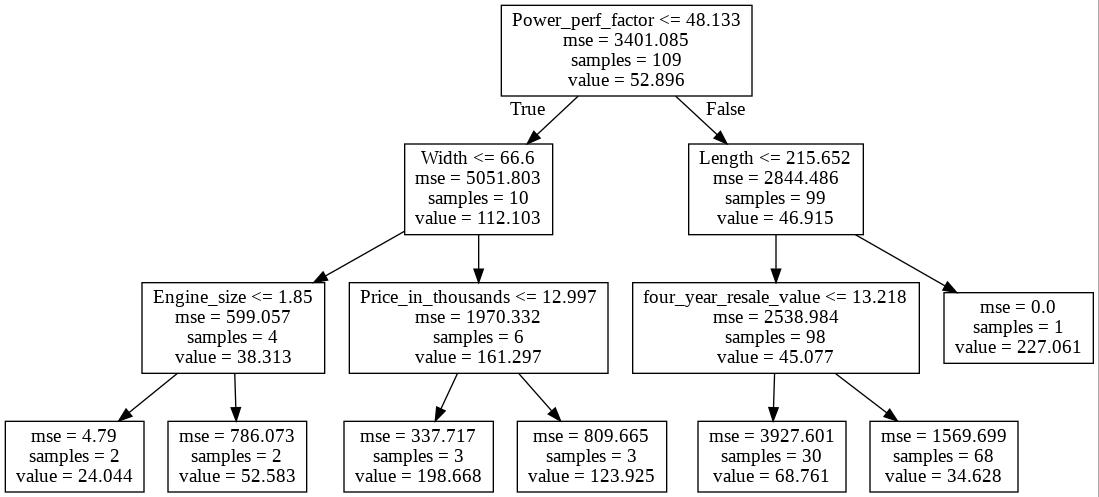

In [167]:
clf_tree_final = DecisionTreeRegressor( max_depth = 3, max_features=9, criterion='mse')
clf_tree_final.fit( train_X, train_y )
export_graphviz(clf_tree_final, out_file='tree1.odt',feature_names=train_X.columns)
tree_graph = pdot.graphviz.graph_from_dot_file('tree1.odt')
tree_graph.write_jpg( 'tree1.jpg' )
Image(filename='tree1.jpg')

In [0]:
# Let's create one more model only with numerical variables
train_X, test_X, train_y, test_y = train_test_split(car_sales_num[features_num],
                                                  car_sales_num['Sales_in_thousands'],
                                                  test_size = 0.3,
                                                  random_state = 142 )

In [169]:
param_grid = {'max_depth': np.arange(3, 20), 'max_features': np.arange(2,12)}
tree_num = GridSearchCV(DecisionTreeRegressor(criterion='mae'), param_grid, cv = 5)
tree_num.fit( train_X, train_y )

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'max_features':

In [170]:
tree_num.best_params_

{'max_depth': 3, 'max_features': 9}

In [171]:
tree_num.best_score_

-0.044236713950395634

## Building final Model

Using above best parameters (depth=3, features=9) we will build our final model.

In [172]:
clf_tree_final = DecisionTreeRegressor( max_depth = 3, max_features=9, criterion='mae')
clf_tree_final.fit( train_X, train_y )

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
tree_test_pred = pd.DataFrame({'actual':test_y, 'predicted':clf_tree_final.predict(test_X)})

In [0]:
export_graphviz(clf_tree_final, out_file='tree.odt',feature_names=train_X.columns)

In [175]:
tree_graph = pdot.graphviz.graph_from_dot_file('tree.odt')
tree_graph.write_jpg( 'tree.jpg' )

True

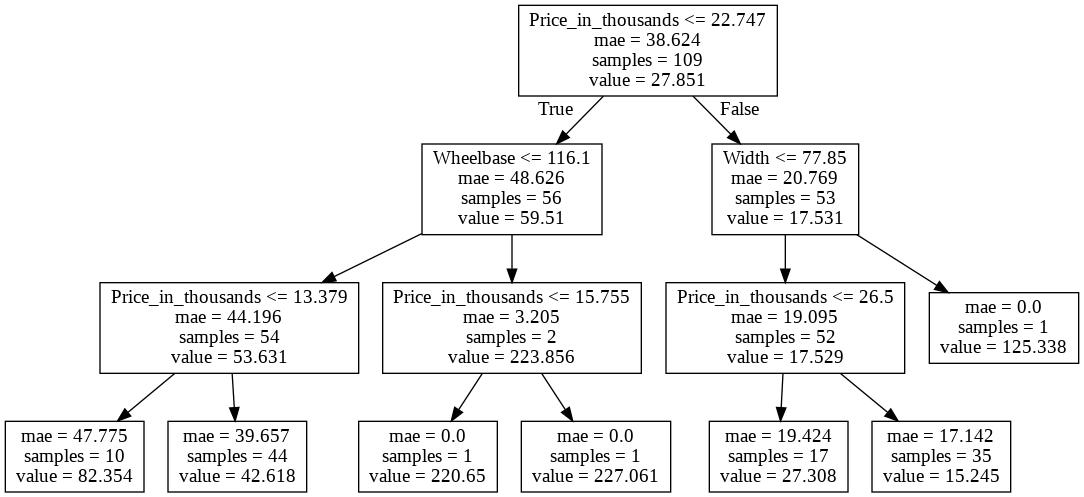

In [176]:
Image(filename='tree.jpg')